참고) https://velog.io/@pkb0126/EDAelectricpowerusage

트랜스포머 모델이 명확한 추세와 주기성을 지닌 장기 시계열 예측에 정말 효과적인가?

https://today-1.tistory.com/60

## Load Data

In [2]:
import re
import seaborn as sns
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore') 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

import zipfile
from zipfile import ZipFile
from io import BytesIO

filepath_zip = '../data/open.zip'
with ZipFile(filepath_zip,'r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename.endswith('.csv'):
            zipRead = zipObj.read(filename)
            globals()[f'{filename[5:-4]}'] = pd.read_csv(BytesIO(zipRead))
            print('df객체명 :',filename[5:-4])

df객체명 : international_trade
df객체명 : sample_submission
df객체명 : test
df객체명 : train


##### train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
- timestamp : 거래 시기 (연-월-일)
- item: 품목 코드
    - TG : 감귤
    - BC : 브로콜리
    - RD : 무
    - CR : 당근
    - CB : 양배추
- corporation : 유통 법인 코드
    - 법인 A부터 F 존재
- location : 지역 코드
    - J : 제주도 제주시
    - S : 제주도 서귀포시
- supply(kg) : 유통된 물량, kg 단위
- price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위 

##### international_trade : 관련 품목 수출입 정보
- 기간 : 연-월
- 품목명 : 요상한 명칭도 있음
- 수출 중량 : 단위 없음
- 수출 금액 : 단위 없음
- 수입 중량 : 단위 없음
- 수입 금액 : 단위 없음
- 무역 수지 : (수출 금액 - 수입 금액)

In [3]:
# rename
train.rename(columns={'supply(kg)':'supply','price(원/kg)':'price'},inplace=True)

In [4]:
# to datetime
for df in [train,test]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df[['year','woy','dow']] = df['timestamp'].dt.isocalendar()[['year','week','day']]
train.head()

,ID,timestamp,item,corporation,location,supply,price,month,day,year,woy,dow
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,1,1,2019,1,2
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,1,2,2019,1,3
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,1,3,2019,1,4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,1,4,2019,1,5
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,1,5,2019,1,6


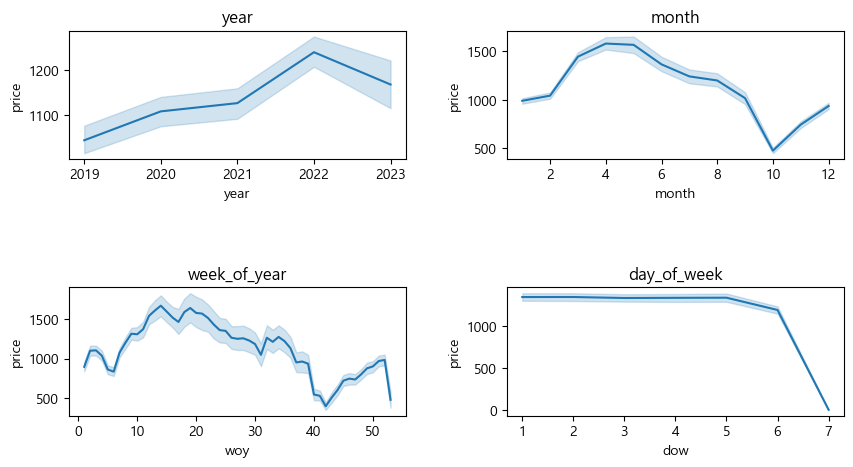

In [5]:
fig, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(hspace=1, wspace=0.3)
for idx, col_name in enumerate(['year','month','woy','dow']):
    row = idx //2
    col = idx%2
    sns.lineplot(data=train, x=col_name, y='price',ax=axs[row][col])
    title = col_name
    if col_name in ['woy','dow']:
        title = 'week_of_year' if col_name=='woy' else 'day_of_week'
    axs[row][col].set_title(title)
fig.show()

In [89]:
import holidays
kr_holidays = holidays.CountryHoliday('KR')

In [96]:
train['isholiday']=train['timestamp'].apply(lambda x : x in kr_holidays)

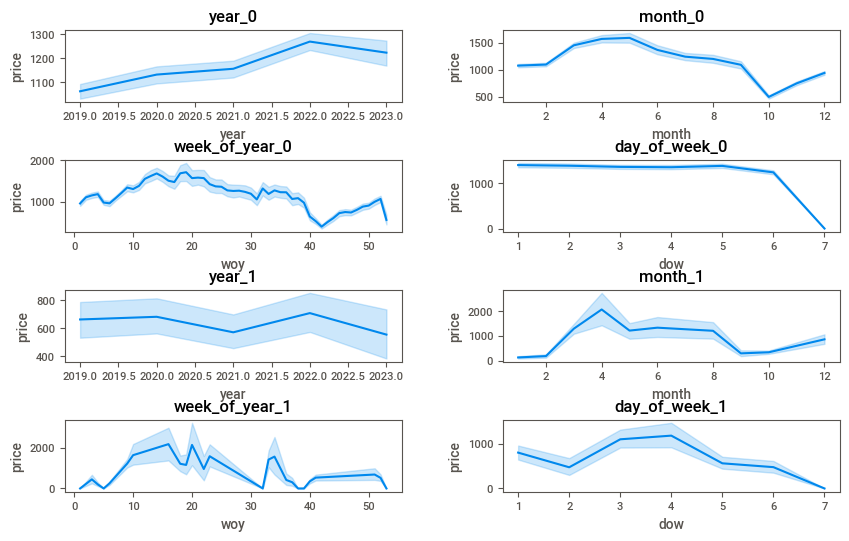

In [103]:
fig, axs = plt.subplots(4,2,figsize=(10,6))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for idx, col_name in enumerate(['year','month','woy','dow','year','month','woy','dow']):
    row = idx //2
    col = idx%2
    holi = idx //4
    subset = train[train['isholiday']==holi]
    sns.lineplot(data=subset, x=col_name, y='price',ax=axs[row][col])
    title = col_name+'_'+str(holi)
    if col_name in ['woy','dow']:
        title = f'week_of_year_{holi}' if col_name=='woy' else f'day_of_week_{holi}'
    axs[row][col].set_title(title)
fig.show()

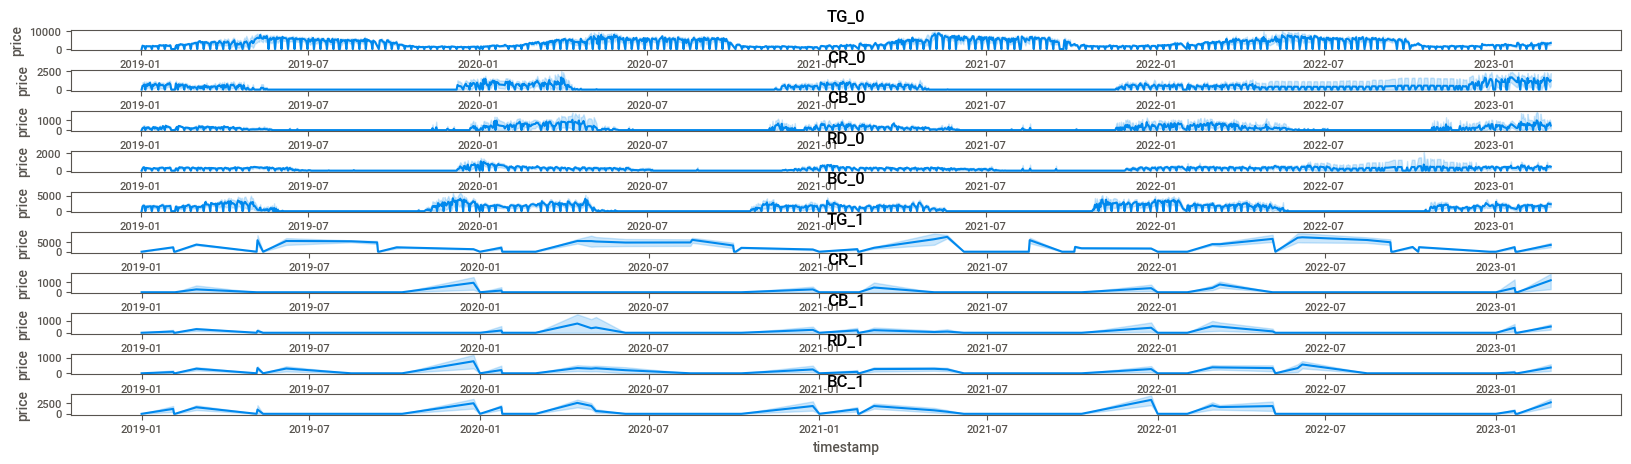

In [118]:
fig, axs = plt.subplots(10,1,figsize=(20,5))
plt.subplots_adjust(hspace=1, wspace=0.3)
col_list = list(train['item'].unique())+list(train['item'].unique())
for idx, item in enumerate(col_list):
    row = idx //1
    col = idx%1
    holi = idx //5
    subset = train[(train['isholiday']==holi) & 
                  (train['item']==item)]
    sns.lineplot(data=subset, x='timestamp', y='price',ax=axs[row])
    title = item+'_'+str(holi)
    axs[row].set_title(title)
fig.savefig('./plots/item_holidays.png')
fig.show()

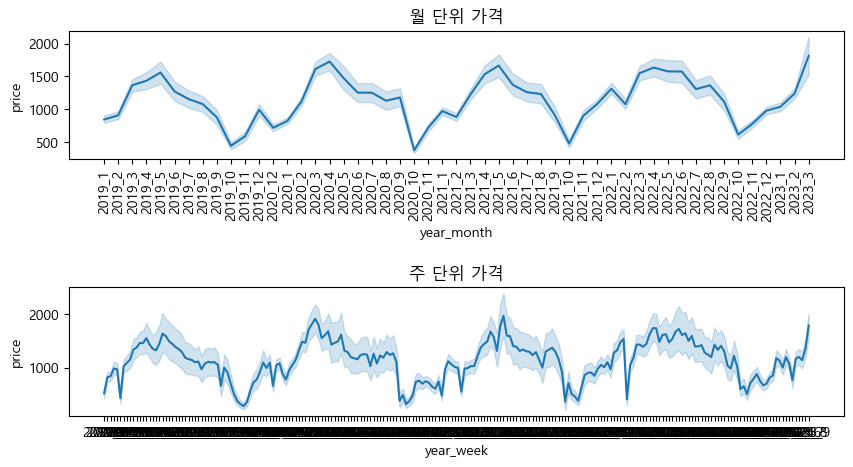

In [19]:
fig, axs = plt.subplots(2,figsize=(10,5))
plt.subplots_adjust(hspace=1)
train['year_month'] = train['year'].astype(str) + '_' + train['month'].astype(str)
sns.lineplot(data=train,x='year_month',y='price',ax=axs[0])
train['year_week'] = train['year'].astype(str) + '_' + train['woy'].astype(str)
sns.lineplot(data=train,x='year_week',y='price',ax=axs[1])
axs[0].set_title('월 단위 가격')
axs[1].set_title('주 단위 가격')
axs[0].tick_params(axis='x', labelrotation=90)
fig.show()

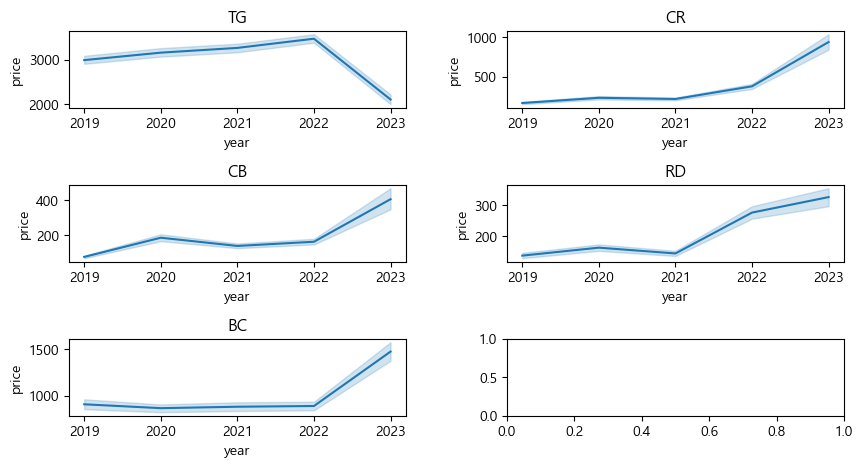

In [38]:
fig, axs = plt.subplots(3,2,figsize=(10,5))
plt.subplots_adjust(hspace=1, wspace=0.3)
for idx,item in enumerate(train['item'].unique()):
    subset = train[train['item']==item]
    sns.lineplot(data=subset,x='year',y='price',ax=axs[idx//2][idx%2])
    axs[idx//2][idx%2].set_title(item)
fig.show()

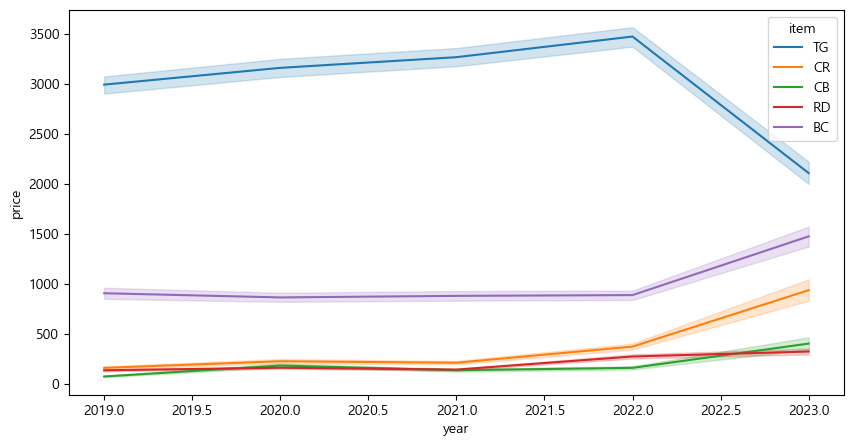

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=train, x='year',y='price',hue='item')
fig.show()

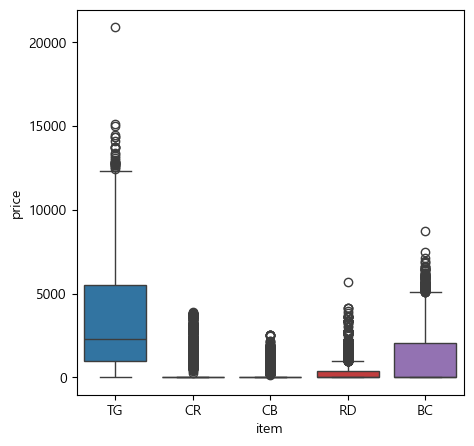

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=train,x='item',y='price',hue='item')
fig.show()

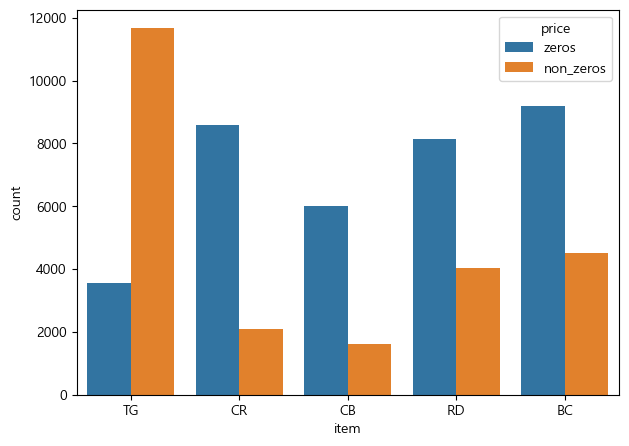

In [72]:
counts = pd.DataFrame(columns = ['item','count'])
for item in train['item'].unique():
    zero_price_cnt = train[(train['item']==item) &
                                  (train['price']==0)]['price'].count()
    non_zero_price_cnt=train[train['item']==item]['price'].count()-zero_price_cnt
#     counts.add(pd.Series([item,zero_price_cnt,non_zero_price_cnt],
#                                   name=['item','zeros','non_zeros']))
    temp = pd.DataFrame(data=[item,'zeros',zero_price_cnt]).transpose()
    temp.columns = ['item','price','count']
    temp2 = pd.DataFrame(data=[item,'non_zeros',non_zero_price_cnt]).transpose()
    temp2.columns = ['item','price','count']
    counts = pd.concat([counts,temp,temp2],axis=0)
counts.set_index(['item','price'],inplace=True)
    
fig,ax = plt.subplots(figsize=(7,5))
sns.barplot(data=counts,x='item',y='count',hue='price')
fig.show()

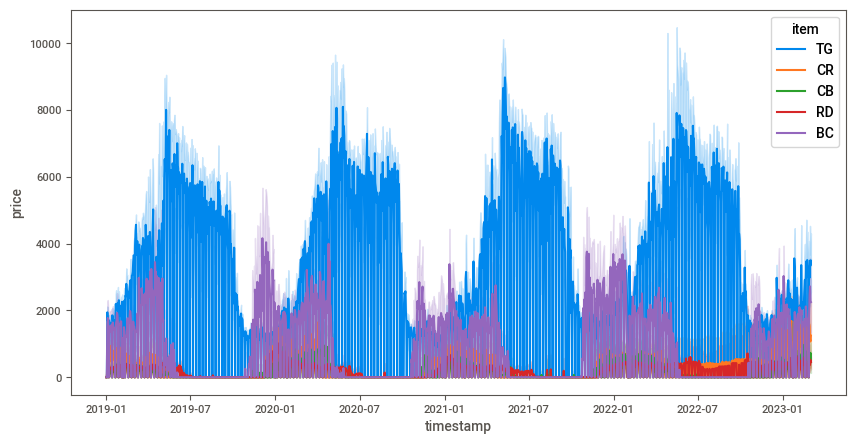

In [87]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=train,x='timestamp',y='price',hue='item')
fig.show()

---
# Sweetviz로 EDA 해보기

In [75]:
import sweetviz as sv

In [78]:
train_viz = pd.read_csv('../data/open/train.csv')
train_viz.rename(columns={'supply(kg)':'supply','price(원/kg)':'price'},inplace=True)
train_viz.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply',
       'price'],
      dtype='object')

In [83]:
feature_config = sv.FeatureConfig(
    skip=['ID'],
    force_num=['supply','price'],
    force_text=['item','corporation','location']
)
train_report = sv.analyze([train_viz,'train_org'],
               target_feat='price',
               feat_cfg=feature_config
                   )

                                             |                  | [  0%]   00:00 -> (? left)

In [85]:
# train_report.show_notebook(filepath='./sweetviz/train_report.html')
train_report.show_html(filepath='./sweetviz/train_report.html')

Report ./sweetviz/train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
